Final Project

In [1]:
# !pip install python-louvain
# !pip install tabulate
# !pip install pandas
# !pip install networkx
# !pip install matplotlib
# !pip install numpy
# !pip install scipy
# !pip install tensorflow
# !pip install scikit-learn
# !pip install seaborn
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np
from scipy.optimize import minimize
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.cluster import KMeans
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
###Data statistics and preprocessing

nasdaq_data = pd.read_csv("NASDAQ_100_Data_From_2010.csv")

# Convert 'Date' column to datetime if it's not already in datetime format
nasdaq_data['Date'] = pd.to_datetime(nasdaq_data['Date'])

# Display the first few rows of the DataFrame
print(nasdaq_data.head())

# Get information about the DataFrame including the count of non-null values in each column
print(nasdaq_data.info())

# Get summary statistics for numerical columns in the DataFrame
print(nasdaq_data.describe())

# Check for missing values in the DataFrame
missing_values = nasdaq_data.isna().sum()
print("Missing values in each column:")
print(missing_values)


        Date      Open      High       Low     Close  Adj Close     Volume  \
0 2010-01-04  7.622500  7.660714  7.585000  7.643214   6.562591  493729600   
1 2010-01-05  7.664286  7.699643  7.616071  7.656429   6.573935  601904800   
2 2010-01-06  7.656429  7.686786  7.526786  7.534643   6.469369  552160000   
3 2010-01-07  7.562500  7.571429  7.466071  7.520714   6.457407  477131200   
4 2010-01-08  7.510714  7.571429  7.466429  7.570714   6.500339  447610800   

   Name  
0  AAPL  
1  AAPL  
2  AAPL  
3  AAPL  
4  AAPL  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271680 entries, 0 to 271679
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       271680 non-null  datetime64[ns]
 1   Open       271680 non-null  float64       
 2   High       271680 non-null  float64       
 3   Low        271680 non-null  float64       
 4   Close      271680 non-null  float64       
 5   Adj Close  271680 no

In [3]:
### 1. Use convex programming to get a portifolio with the highest return-to-variance deviation value

# Extract year from the 'Date' column
nasdaq_data['Year'] = nasdaq_data['Date'].dt.year

# Filter data for years 2010 to 2020 as 2021 doesn't contains full-year data 
nasdaq_data = nasdaq_data[(nasdaq_data['Date'].dt.year >= 2010) & (nasdaq_data['Date'].dt.year <= 2020)]

# Calculate yearly returns for each stock
yearly_returns = nasdaq_data.groupby(['Name', 'Year'])['Adj Close'].last() / nasdaq_data.groupby(['Name', 'Year'])['Adj Close'].first() - 1

# Pivot yearly returns data to get a DataFrame where columns are stocks and rows are years
returns_pivot = yearly_returns.unstack(level='Name')

# Calculate covariance matrix of asset yearly returns
covariance_matrix = returns_pivot.cov()

# Convert covariance matrix to numpy array
covariance_matrix_np = covariance_matrix.values

# Define expected yearly returns
expected_returns = yearly_returns.groupby('Name').mean()

# Define the objective function
def objective(weights, cov_matrix):
    portfolio_return = np.sum(weights * expected_returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    ratio = portfolio_return / portfolio_variance
    return -ratio  # Minimize negative ratio

# Define constraints
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},)  # Sum of weights = 1

# Bounds on weights (optional)
bounds = tuple((0, 1) for asset in range(len(expected_returns)))

# Initial guess for weights
init_guess = np.array([1. / len(expected_returns) for _ in range(len(expected_returns))])

# Run optimization
opt_results = minimize(objective, init_guess, args=(covariance_matrix_np,),
                       method='SLSQP', constraints=constraints, bounds=bounds)

# Extract optimal weights
optimal_weights = opt_results.x

# Calculate portfolio statistics
portfolio_return = np.sum(optimal_weights * expected_returns)
portfolio_variance = np.dot(optimal_weights.T, np.dot(covariance_matrix_np, optimal_weights))

# Print the results
print("Optimal Portfolio Weights:", optimal_weights)
print("Portfolio Return:", portfolio_return)
print("Portfolio Variance:", portfolio_variance)



Optimal Portfolio Weights: [2.54911847e-05 3.29265664e-05 2.69896689e-05 3.72463444e-05
 1.75394089e-05 3.92856255e-05 6.87355018e-06 3.58186753e-05
 1.36474302e-01 3.62862093e-05 8.71619817e-11 3.06727137e-05
 3.85479782e-05 5.36465428e-06 2.25584592e-05 1.47245940e-05
 3.44804095e-05 3.03975065e-05 2.20016088e-05 4.68820137e-01
 3.31702843e-05 3.34780797e-05 2.39402028e-05 3.48551432e-05
 2.64556565e-05 3.39990503e-05 4.39688113e-04 4.76556199e-05
 3.23550828e-05 2.81172397e-05 2.69023357e-05 2.98748958e-05
 9.24636558e-03 1.54046748e-01 2.04258157e-05 4.62442815e-05
 4.36628461e-05 2.60028206e-05 2.06941007e-05 3.54964513e-05
 3.94405838e-05 3.68300393e-05 3.01771049e-05 3.42079515e-05
 3.38216049e-05 3.10563681e-05 2.00234201e-05 3.49157510e-05
 1.51520623e-05 4.21362922e-05 2.54791688e-05 4.21653042e-05
 3.12552100e-05 4.00678663e-05 4.21385318e-05 2.32261869e-05
 2.51445236e-05 1.95211800e-05 4.03773010e-05 2.67884323e-05
 2.79739969e-05 3.07379101e-05 2.55872888e-05 2.18957015e-

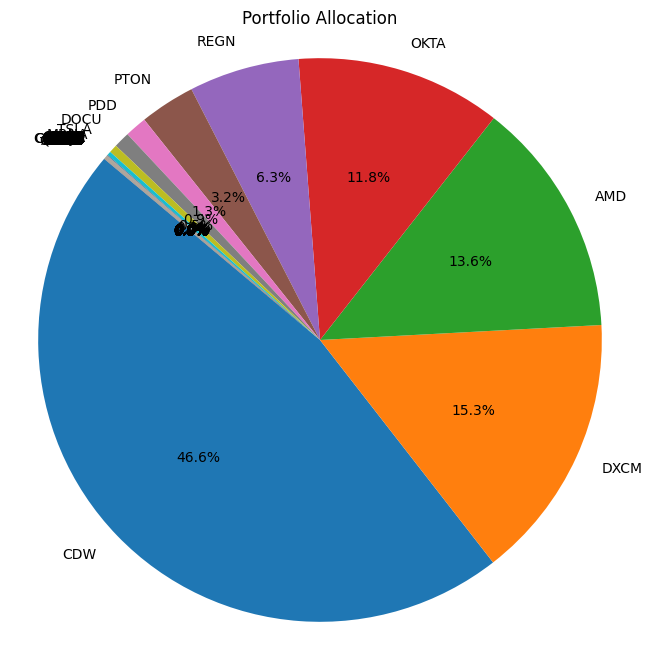

Ranked Portfolio Weights:
1. CDW: 46.9%
2. DXCM: 15.4%
3. AMD: 13.6%
4. OKTA: 11.9%
5. REGN: 6.4%
6. PTON: 3.2%
7. PDD: 1.3%
8. DOCU: 0.9%
9. TSLA: 0.5%
10. MRNA: 0.2%
11. CRWD: 0.0%
12. CSCO: 0.0%
13. EBAY: 0.0%
14. EXC: 0.0%
15. VRSN: 0.0%
16. ISRG: 0.0%
17. KHC: 0.0%
18. INTC: 0.0%
19. NVDA: 0.0%
20. WBA: 0.0%
21. MAR: 0.0%
22. KDP: 0.0%
23. WDAY: 0.0%
24. FOX: 0.0%
25. AEP: 0.0%
26. ZM: 0.0%
27. ASML: 0.0%
28. ADP: 0.0%
29. SPLK: 0.0%
30. FOXA: 0.0%
31. AMGN: 0.0%
32. AMAT: 0.0%
33. FISV: 0.0%
34. XEL: 0.0%
35. ILMN: 0.0%
36. CMCSA: 0.0%
37. BIIB: 0.0%
38. SIRI: 0.0%
39. GOOG: 0.0%
40. CPRT: 0.0%
41. GOOGL: 0.0%
42. PEP: 0.0%
43. CHKP: 0.0%
44. CERN: 0.0%
45. PAYX: 0.0%
46. ADBE: 0.0%
47. TCOM: 0.0%
48. CSX: 0.0%
49. ROST: 0.0%
50. JD: 0.0%
51. HON: 0.0%
52. MELI: 0.0%
53. ANSS: 0.0%
54. BKNG: 0.0%
55. GILD: 0.0%
56. DLTR: 0.0%
57. ORLY: 0.0%
58. VRSK: 0.0%
59. CTAS: 0.0%
60. MSFT: 0.0%
61. MDLZ: 0.0%
62. XLNX: 0.0%
63. NXPI: 0.0%
64. ADI: 0.0%
65. CTSH: 0.0%
66. MCHP: 0.0%
67. TEA

In [4]:
###visualize the optimal result

# Get the names of stocks
stock_names = expected_returns.index

# Sort the optimal weights and stock names together
sorted_weights, sorted_names = zip(*sorted(zip(optimal_weights, stock_names), reverse=True))

# Plotting
plt.figure(figsize=(8, 8))
shown_weights = [ x for x in sorted_weights if x>0]
top_n = len(shown_weights)
plt.pie(sorted_weights[:top_n], labels=sorted_names[:top_n], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Portfolio Allocation')
plt.show()

# Displaying the ranked weights and stock names
print("Ranked Portfolio Weights:")
for i, (weight, name) in enumerate(zip(sorted_weights, sorted_names), 1):
    print(f"{i}. {name}: {weight*100:.1f}%")


C:\Users\Yuhui Lin\AppData\Local\Temp\ipykernel_17052\1990625027.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nasdaq_data_aapl.dropna(inplace=True)
C:\Users\Yuhui Lin\AppData\Local\Temp\ipykernel_17052\1990625027.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aapl['Adj Close'] = scaler.fit_transform(nasdaq_data_aapl[['Adj Close']])



Epoch 1/30

69/69 [==============================] - 5s 19ms/step - loss: 0.0019 - val_loss: 7.4892e-04
Epoch 2/30
69/69 [==============================] - 1s 8ms/step - loss: 1.9305e-04 - val_loss: 8.0770e-04
Epoch 3/30
69/69 [==============================] - 1s 8ms/step - loss: 1.4639e-04 - val_loss: 6.6074e-04
Epoch 4/30
69/69 [==============================] - 1s 8ms/step - loss: 1.6265e-04 - val_loss: 6.5167e-04
Epoch 5/30
69/69 [==============================] - 1s 8ms/step - loss: 1.6849e-04 - val_loss: 7.0413e-04
Epoch 6/30
69/69 [==============================] - 1s 8ms/step - loss: 1.3271e-04 - val_loss: 6.5897e-04
Epoch 7/30
69/69 [==============================] - 1s 8ms/step - loss: 1.4056e-04 - val_loss: 0.0013
Epoch 8/30
69/69 [==============================] - 1s 8ms/step - loss: 1.3921e-04 - val_loss: 6.1216e-04
Epoch 9/30
69/69 [==============================] - 1s 7ms/step - loss: 1.3051e-04 - val_loss: 6.6875e-04
Epoch 10/30
69/69 [==============================] 

C:\Users\Yuhui Lin\AppData\Local\Temp\ipykernel_17052\1990625027.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aapl['Adj Close'] = scaler.inverse_transform(df_aapl[['Adj Close']])


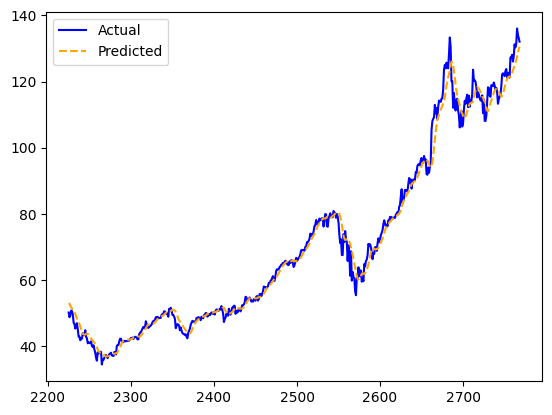

In [5]:
### 2.use machine learning algorithm (LSTM) to predict the daily price of a stock(Apple as a example here)

# Filter data for Apple (AAPL)
nasdaq_data_aapl = nasdaq_data[nasdaq_data['Name'] == 'AAPL']

# Drop unnecessary columns and handle missing values
df_aapl = nasdaq_data_aapl[['Date', 'Adj Close']]
nasdaq_data_aapl.dropna(inplace=True)

# # Scale the features
scaler = MinMaxScaler()
df_aapl['Adj Close'] = scaler.fit_transform(nasdaq_data_aapl[['Adj Close']])

# Split the data into training and validation sets
train_size = int(len(df_aapl) * 0.8)
train_data, val_data = df_aapl[:train_size], df_aapl[train_size:]

# Prepare the data for training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        sequences.append(sequence)
    return np.array(sequences)

seq_length = 10  # Sequence length
X_train = create_sequences(train_data['Adj Close'].values, seq_length)
y_train = train_data['Adj Close'][seq_length:]

X_val = create_sequences(val_data['Adj Close'].values, seq_length)
y_val = val_data['Adj Close'][seq_length:]

# Model Architecture Design
model = Sequential([
    LSTM(64, input_shape=(seq_length, 1), return_sequences=True),  # LSTM layer with 64 units
    Dropout(0.2),
    LSTM(64),  # Another LSTM layer with 64 units
    Dropout(0.2),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=1)

# Make predictions on the validation set (scaled values)
predictions_scaled = model.predict(X_val)

# Inverse transform the predictions to get the original (unscaled) values
predictions = scaler.inverse_transform(predictions_scaled)

df_aapl['Adj Close'] = scaler.inverse_transform(df_aapl[['Adj Close']])

# Split the data into training and validation sets
train_size = int(len(df_aapl) * 0.8)
train_data, val_data = df_aapl[:train_size], df_aapl[train_size:]

# Prepare the data for training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        sequences.append(sequence)
    return np.array(sequences)

seq_length = 10  # Sequence length
X_train = create_sequences(train_data['Adj Close'].values, seq_length)
y_train = train_data['Adj Close'][seq_length:]

X_val = create_sequences(val_data['Adj Close'].values, seq_length)
y_val = val_data['Adj Close'][seq_length:]

# Plot both the predicted and real values
plt.plot(y_val.index, y_val, label='Actual', color='blue')
plt.plot(y_val.index, predictions, label='Predicted', color='orange', linestyle='dashed')
plt.legend()
plt.show()


In [12]:
### 3.Dynamic programming for deciding investment timing 

#Get the latest 20-day predicted price and actual price
predicted_prices = list(predictions)[-20:]
actual_prices = list(y_val)[-20:]

# Function to find out maximum profit by buying & selling a share atmost k times given stock price of n days
# n: the total number of days
# k: the maximum number of transactions allowed
# prices: a list of stock prices for each day
def maxProfit(n, k, prices):
    # Initialize a 2D list to store the maximum profit for each day and each number of transactions
    profit = [[0] * (k + 1) for _ in range(n)]
    
    # Initialize 2D lists to store the buy and sell points for each day and each number of transactions
    buy_points = [[[] for _ in range(k + 1)] for _ in range(n)]
    sell_points = [[[] for _ in range(k + 1)] for _ in range(n)]
    
    # Iterate over the days
    for i in range(1, n):
        # Iterate over the number of transactions allowed
        for j in range(1, k + 1):
            max_so_far = 0  # Maximum profit found so far
            buy_idx = None  # Index of the day to buy
            sell_idx = None  # Index of the day to sell
            
            # Iterate over the days before the current day
            for l in range(i):
                # Calculate the potential profit by selling on day i after having bought on day l and taking into account the previous maximum profit for j-1 transactions
                current_profit = prices[i] - prices[l] + profit[l][j - 1]
                
                # If the current profit is greater than the maximum profit found so far
                if current_profit > max_so_far:
                    max_so_far = current_profit  # Update the maximum profit
                    buy_idx = l  # Update the day to buy
                    sell_idx = i  # Update the day to sell
            
            # Update the maximum profit for day i and j transactions
            profit[i][j] = max(profit[i - 1][j], max_so_far)
            
            # If the maximum profit involves a buy and sell operation
            if profit[i][j] == max_so_far:
                # Update the buy and sell points
                buy_points[i][j] = buy_points[buy_idx][j - 1] + [buy_idx]
                sell_points[i][j] = sell_points[buy_idx][j - 1] + [sell_idx]
            else:
                # Copy the buy and sell points from the previous day
                buy_points[i][j] = buy_points[i - 1][j]
                sell_points[i][j] = sell_points[i - 1][j]
    
    # Return the maximum profit, buy points, and sell points for n-1 days and k transactions
    return profit[n - 1][k], buy_points[n - 1][k], sell_points[n - 1][k]


n = len(predicted_prices)  # Number of days
#assume we can at most make 3 transactions in 20 days and we want to get the maximum profit based on predicted stock prices
max_predicted_profit, buy_points, sell_points = maxProfit(n, 3, predicted_prices)

print("Maximum predicted profit:", max_predicted_profit[0])
print("Buy points:", buy_points)
print("Sell points:", sell_points)

#based on the buy and sell points from predicted prices, we use real data to validate if this investing timing strategy can work
actual_profit = 0
for i in range(len(buy_points)):
    buy_idx = buy_points[i]
    sell_idx = sell_points[i]
    
    buy_price = actual_prices[buy_idx]
    sell_price = actual_prices[sell_idx]
    
    transaction_profit = sell_price - buy_price
    actual_profit += transaction_profit

print(f"Actual profit: {actual_profit}")
print(f"Does the strategy work: {'Yes' if actual_profit > 0 else 'No'}")


Maximum predicted profit: 13.335449
Buy points: [0, 8]
Sell points: [7, 19]
Actual profit: 3.632934600000013
Does the strategy work: Yes


C:\Users\Yuhui Lin\AppData\Local\Temp\ipykernel_17052\825592101.py:8: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  yearly_volume = nasdaq_data.groupby(['Name', 'Year'])['Volume'].apply(sum)
c:\Users\Yuhui Lin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Yuhui Lin\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOK

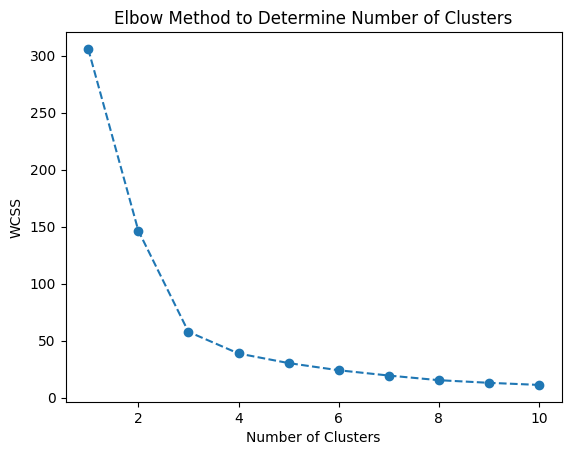

c:\Users\Yuhui Lin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


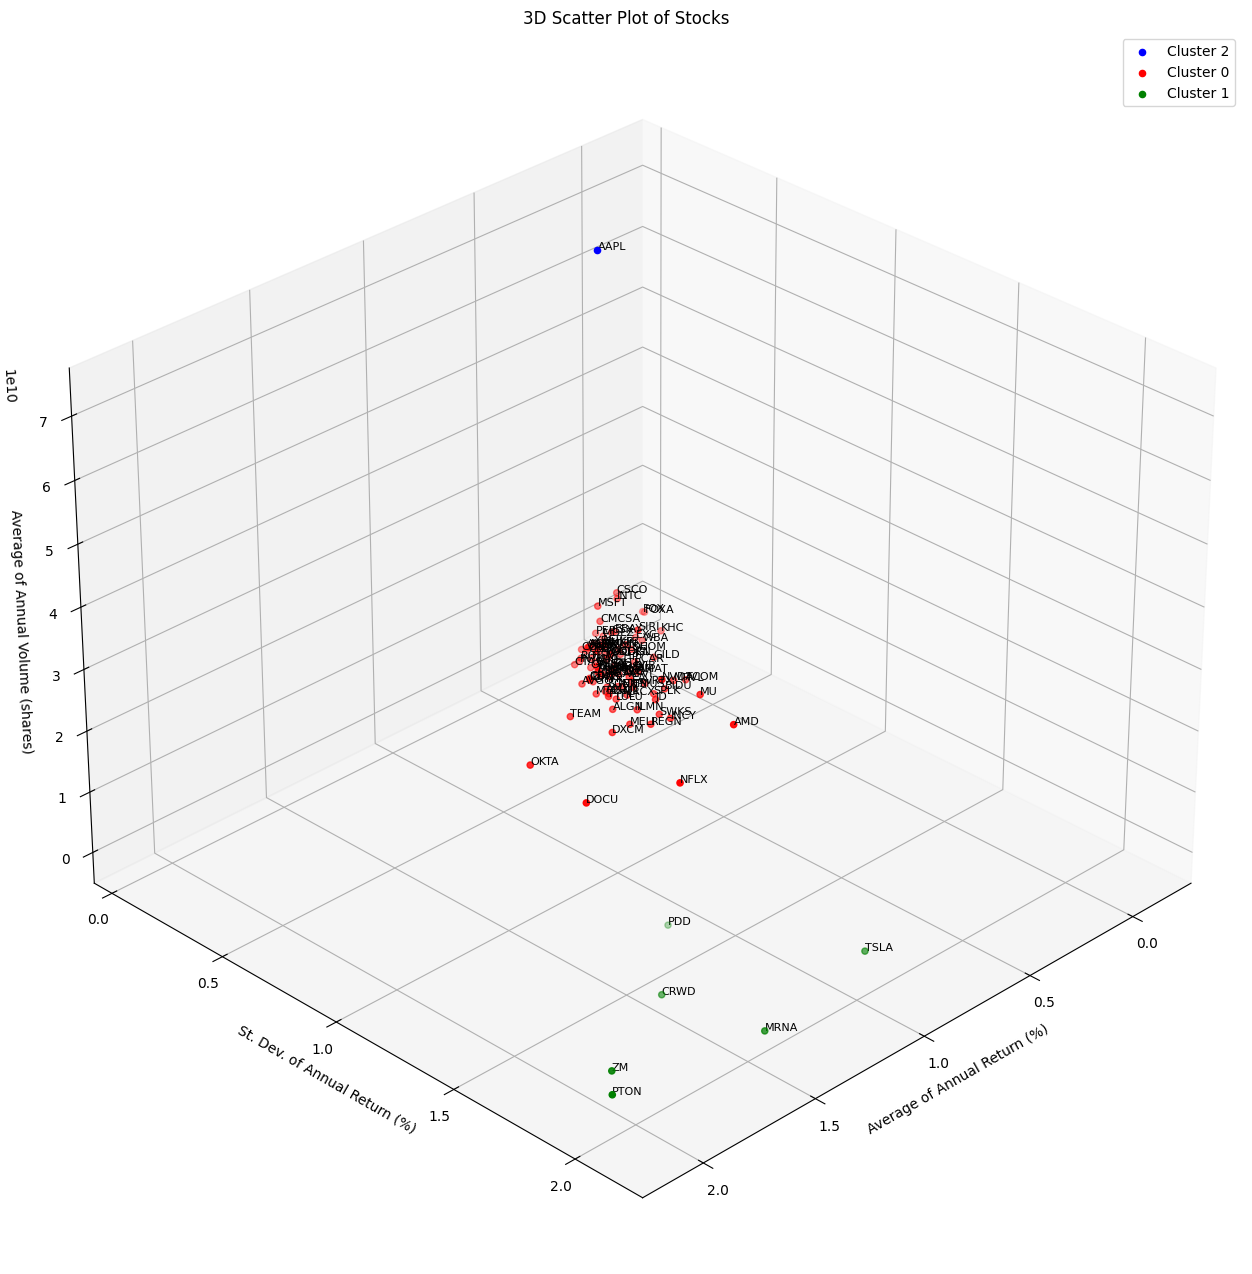

In [7]:
### 4.use machine learning algorithm (K-means) to group stocks based on average yearly return & standard deviation of yearly return

# Calculate yearly returns & variance of annual returns for each stock
yearly_returns = nasdaq_data.groupby(['Name', 'Year'])['Adj Close'].last() / nasdaq_data.groupby(['Name', 'Year'])['Adj Close'].first() - 1
average_yearly_return = yearly_returns.groupby('Name').apply(lambda x: x.mean())
std_yearly_return = yearly_returns.groupby('Name').apply(lambda x: (((x - x.mean())**2).sum() / len(x))**(0.5))

yearly_volume = nasdaq_data.groupby(['Name', 'Year'])['Volume'].apply(sum)
average_yearly_volume = yearly_volume.groupby('Name').apply(lambda x: x.mean())

# Combine into a DataFrame
returns_df = pd.DataFrame({'Stock': average_yearly_return.index,
                           'Average of Annual Return': average_yearly_return,
                           'St. Dev. of Annual Return': std_yearly_return,
                           'Average of Annual Volume': average_yearly_volume})

# Prepare data for clustering
X = returns_df[['Average of Annual Return', 'St. Dev. of Annual Return', 'Average of Annual Volume']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method to find suitable number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=6)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method to Determine Number of Clusters')
plt.show()

# Perform K-means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=3, random_state=6)
returns_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Create a 3D figure
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(projection='3d')

# Create a 3D scatter plot
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # List of colors for each cluster
for cluster in returns_df['Cluster'].unique():
    cluster_data = returns_df[returns_df['Cluster'] == cluster]
    ax.scatter(cluster_data['Average of Annual Return'], cluster_data['St. Dev. of Annual Return'], cluster_data['Average of Annual Volume'], c=colors[cluster], label=f'Cluster {cluster}', marker='o')

    # Add stock names to the data points
    for stock_name, x, y, z in zip(cluster_data['Stock'], cluster_data['Average of Annual Return'], cluster_data['St. Dev. of Annual Return'], cluster_data['Average of Annual Volume']):
        ax.text(x, y, z, stock_name, fontsize=8)

# Add labels and title with units
ax.set_xlabel('Average of Annual Return (%)')
ax.set_ylabel('St. Dev. of Annual Return (%)')
ax.set_zlabel('Average of Annual Volume (shares)')
ax.set_title('3D Scatter Plot of Stocks')

# Add legend
ax.legend()

# Rotate the plot for a better view
ax.view_init(30, 45)

# Display the plot
plt.show()


In [8]:
###reload the original data for analysis with graph algorithm

# Load NASDAQ data
nasdaq_data = pd.read_csv("NASDAQ_100_Data_From_2010.csv")

# Convert 'Date' column to datetime format
nasdaq_data['Date'] = pd.to_datetime(nasdaq_data['Date'])

nasdaq_data.sort_values(by=['Name', 'Date'], inplace=True)

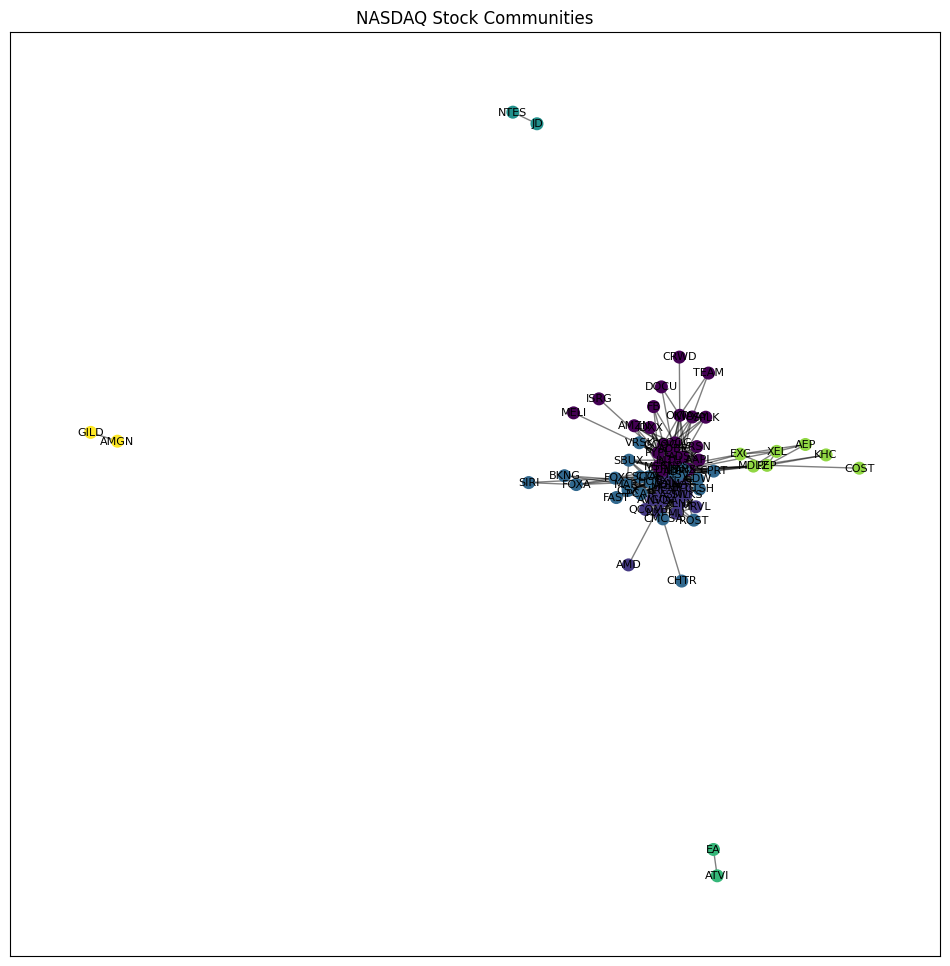

Number of communities detected: 7
Community partition: {'AAPL': 0, 'ADI': 1, 'AMAT': 1, 'ANSS': 0, 'GOOG': 0, 'GOOGL': 0, 'INTU': 0, 'KLAC': 1, 'MSFT': 0, 'PYPL': 0, 'SNPS': 0, 'SWKS': 1, 'TXN': 1, 'ADBE': 0, 'ADP': 2, 'ADSK': 0, 'AMZN': 0, 'CDNS': 0, 'DOCU': 0, 'FISV': 2, 'MCHP': 1, 'NVDA': 1, 'OKTA': 0, 'PAYX': 2, 'SPLK': 0, 'VRSN': 0, 'WDAY': 0, 'ASML': 1, 'AVGO': 1, 'CDW': 2, 'CSCO': 2, 'CSX': 2, 'CTAS': 2, 'CTSH': 2, 'HON': 2, 'INTC': 1, 'LRCX': 1, 'MAR': 2, 'MRVL': 1, 'MU': 1, 'NXPI': 1, 'PCAR': 2, 'QCOM': 1, 'XLNX': 1, 'CMCSA': 2, 'CPRT': 2, 'FAST': 2, 'MDLZ': 5, 'PEP': 5, 'SBUX': 2, 'VRSK': 2, 'AEP': 5, 'EXC': 5, 'XEL': 5, 'AMD': 1, 'AMGN': 6, 'GILD': 6, 'ATVI': 4, 'EA': 4, 'BKNG': 2, 'IDXX': 0, 'CHTR': 2, 'FOX': 2, 'COST': 5, 'CRWD': 0, 'FOXA': 2, 'FB': 0, 'ROST': 2, 'SIRI': 2, 'ISRG': 0, 'JD': 3, 'NTES': 3, 'KHC': 5, 'MELI': 0, 'TEAM': 0}


In [9]:
### 5.Community Detection with Graph Utilization
# Calculate returns and create the correlation matrix
nasdaq_data['Return'] = nasdaq_data.groupby('Name')['Adj Close'].pct_change()
returns_pivot = nasdaq_data.pivot_table(values='Return', index='Date', columns='Name')
correlation_matrix = returns_pivot.corr()

# Define a threshold for significant correlation and create the graph
threshold = 0.5
G = nx.Graph()
for stock1 in correlation_matrix.columns:
    for stock2 in correlation_matrix.columns:
        if stock1 != stock2 and correlation_matrix.loc[stock1, stock2] > threshold:
            G.add_edge(stock1, stock2, weight=correlation_matrix.loc[stock1, stock2])

# Apply the Louvain method for community detection
partition = community_louvain.best_partition(G)

# Visualization of the graph with communities
pos = nx.spring_layout(G)  # positions for all nodes
plt.figure(figsize=(12, 12))
cmap = plt.get_cmap('viridis')
nx.draw_networkx_nodes(G, pos, node_size=70, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
plt.title('NASDAQ Stock Communities')
plt.show()

# Output the number of communities detected and the partition
num_communities = len(set(partition.values()))
print(f"Number of communities detected: {num_communities}")
print("Community partition:", partition)

In [10]:
# Updated Community partition data as provided
community_partition = {
    'AAPL': 2, 'ADI': 1, 'AMAT': 1, 'ANSS': 2, 'GOOG': 2, 'GOOGL': 2, 'INTU': 2,
    'KLAC': 1, 'MSFT': 2, 'PYPL': 2, 'SNPS': 2, 'SWKS': 1, 'TXN': 1, 'ADBE': 2,
    'ADP': 3, 'ADSK': 2, 'AMZN': 2, 'CDNS': 2, 'DOCU': 2, 'FISV': 3, 'MCHP': 1,
    'NVDA': 1, 'OKTA': 2, 'PAYX': 3, 'SPLK': 2, 'VRSN': 2, 'WDAY': 2, 'ASML': 1,
    'AVGO': 1, 'CDW': 3, 'CSCO': 3, 'CSX': 3, 'CTAS': 3, 'CTSH': 3, 'HON': 3,
    'INTC': 1, 'LRCX': 1, 'MAR': 3, 'MRVL': 1, 'MU': 1, 'NXPI': 1, 'PCAR': 3,
    'QCOM': 1, 'XLNX': 1, 'CMCSA': 3, 'CPRT': 3, 'FAST': 3, 'MDLZ': 4, 'PEP': 4,
    'SBUX': 3, 'VRSK': 3, 'AEP': 4, 'EXC': 4, 'XEL': 4, 'AMD': 1, 'AMGN': 5,
    'GILD': 5, 'ATVI': 6, 'EA': 6, 'BKNG': 3, 'IDXX': 2, 'CHTR': 3, 'FOX': 3,
    'COST': 4, 'CRWD': 2, 'FOXA': 3, 'FB': 2, 'ROST': 3, 'SIRI': 3, 'ISRG': 2,
    'JD': 0, 'NTES': 0, 'KHC': 4, 'MELI': 2, 'TEAM': 2
}

# Organize companies by their community number
groupings = {}
for company, community in community_partition.items():
    if community not in groupings:
        groupings[community] = []
    groupings[community].append(company)

# Prepare the data for tabulate
table_data = []
for community, companies in sorted(groupings.items()):
    table_data.append([community, ', '.join(companies)])

# Print the table using tabulate
print(tabulate(table_data, headers=['Community ID', 'Companies'], tablefmt='fancy_grid'))


╒════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│   Community ID │ Companies                                                                                                                               │
╞════════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│              0 │ JD, NTES                                                                                                                                │
├────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│              1 │ ADI, AMAT, KLAC, SWKS, TXN, MCHP, NVDA, ASML, AVGO, INTC, LRCX, MRVL, MU, NXPI, QCOM, XLNX, AMD                                         │
├────────────────┼────────────────────────────────────────

In [11]:
### 6. Degree Centrality with Graph Utilization
degree_centrality = nx.degree_centrality(G)

# Convert centrality dictionaries to sorted lists for better analysis
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 stocks for each centrality measure
top_10_degree = sorted_degree[:10]

top_10_degree

# Create a DataFrame from the top 10 degree centrality
df = pd.DataFrame(top_10_degree, columns=['Stock', 'Degree Centrality'])

# Print the DataFrame
print(tabulate(df, headers='keys', tablefmt='grid'))

+----+---------+---------------------+
|    | Stock   |   Degree Centrality |
+====+=========+=====================+
|  0 | TXN     |            0.5      |
+----+---------+---------------------+
|  1 | PAYX    |            0.5      |
+----+---------+---------------------+
|  2 | FISV    |            0.486486 |
+----+---------+---------------------+
|  3 | ADI     |            0.472973 |
+----+---------+---------------------+
|  4 | ADP     |            0.472973 |
+----+---------+---------------------+
|  5 | HON     |            0.472973 |
+----+---------+---------------------+
|  6 | PYPL    |            0.459459 |
+----+---------+---------------------+
|  7 | SNPS    |            0.459459 |
+----+---------+---------------------+
|  8 | MCHP    |            0.459459 |
+----+---------+---------------------+
|  9 | INTU    |            0.418919 |
+----+---------+---------------------+
